# README

This python notebook is broken into 2 parts.

1. A visualization of the whole algorithm. Each cell shows a different part of the algorithm with an example set of pictures. This way, you can verify that the algorithm was implemented correctly and according to assignment specs.

2. At the very bottom of this notebook, there is a simple interface for loading your own pictures into the algorithm. Make sure to load the base image as the second picture (it is assumed to be the centeral image).

Lastly, be aware that I implemented an edge compositor for the extension part of the project. I couldn't quite finish it before the due date. I got close. I was able to find the edges of the pictures, but when I tried to blur between points, it didn't work as I was expecting. You can see it's effect by changing the withBlur value to True.

Please let me know if you have any questions. davidhart100@gmail.com

## Final Write-up

Overall, the project went really well. It took about 10 hours total and had a lot of steps to it, but I found it quite enjoyable. I thought most of the steps were pretty straight forward, however, it would have been nice to have more examples on how to warp an image before starting the lab. Maybe a part 1 of the lab could be to do a simple warp perspective on an image (like I did for the whiteboard from class). Other than that, it was a great project.

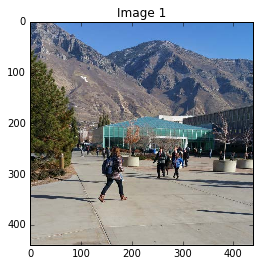

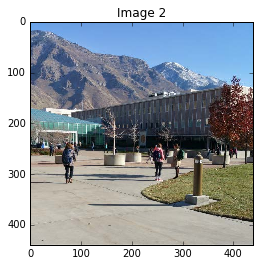

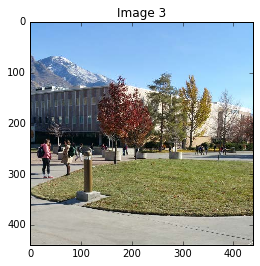

In [116]:
import cv2
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt

def plotImage(image,title=""):
    plt.imshow(image, cmap='gray', interpolation = 'none')
    plt.title(title)
    plt.show()

def GrayScale(image):
    red = image[:,:,0]
    green = image[:,:,1]
    blue = image[:,:,2]
    result = 0.299*red + 0.557*green + 0.114*blue
    return result

def getImages(fn1,fn2,fn3):
    color1 = cv2.cvtColor(cv2.imread(fn1),cv2.COLOR_BGR2RGB)
    color2 = cv2.cvtColor(cv2.imread(fn2),cv2.COLOR_BGR2RGB)
    color3 = cv2.cvtColor(cv2.imread(fn3),cv2.COLOR_BGR2RGB)

    grey1 = cv2.cvtColor(cv2.imread(fn1),cv2.COLOR_BGR2GRAY)
    grey2 = cv2.cvtColor(cv2.imread(fn2),cv2.COLOR_BGR2GRAY)
    grey3 = cv2.cvtColor(cv2.imread(fn3),cv2.COLOR_BGR2GRAY)

    return color1, color2, color3, grey1, grey2, grey3
    
    
color1, color2, color3, image1, image2, image3 = getImages('stitch1.jpg', 'stitch2.jpg', 'stitch3.jpg')
    
plotImage(color1, "Image 1")
plotImage(color2, "Image 2")
plotImage(color3, "Image 3")

# Part A: Finding Interest Points

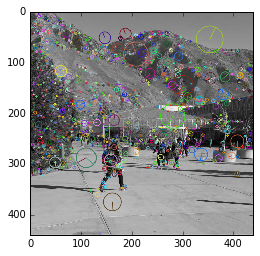

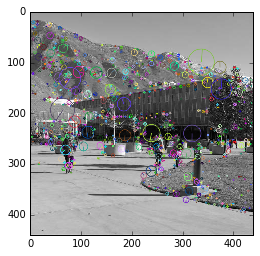

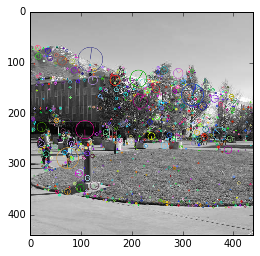

In [117]:
def getKeyPoints(image1, image2, image3):
    #Generate Sifting Algorithm
    sift = cv2.xfeatures2d.SIFT_create()

    #Generate Key Points for Image1
    kp1, des1 = sift.detectAndCompute(image1,None)
    img1=cv2.drawKeypoints(image1,kp1,image1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #cv2.imwrite('sift_keypoints.jpg',img)

    #Generate Key Points for Image2
    kp2, des2 = sift.detectAndCompute(image2,None)
    img2=cv2.drawKeypoints(image2,kp2,image2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    #Generate Key Points for Image3
    kp3, des3 = sift.detectAndCompute(image3,None)
    img3=cv2.drawKeypoints(image3,kp3,image3, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return ((img1, kp1, des1), (img2, kp2, des2), (img3, kp3, des3))
    
vals1, vals2, vals3 = getKeyPoints(image1, image2, image3)    
    
plotImage(vals1[0])
plotImage(vals2[0])
plotImage(vals3[0])


# Part B: Matching Features

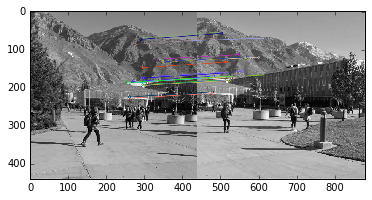

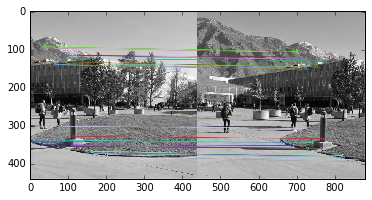

In [118]:
def bfMatcher(vals1, vals2, image1, image2):
    
    #Unpack values
    img1, kp1, des1 = vals1
    img2, kp2, des2 = vals2
    
    bf = cv2.BFMatcher()

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Draw first 25 matches.
    img = cv2.drawMatches(image1,kp1,image2,kp2, matches[:25], image2, flags=2)

    return img, matches


img1_2, matches1_2 = bfMatcher(vals1,vals2,image1,image2)
img3_2, matches3_2 = bfMatcher(vals3,vals2,image3,image2)

plotImage(img1_2)
plotImage(img3_2)

# Part C: Implementing RANSAC

In [119]:
# Simpler Function for Full Implementation

def getHomography(kp1,kp2,matches,n1,n2,n3,n4):

    #Get the optimal transformation coordinates for the first image
    dmatch = matches[n1]
    x0s = kp1[dmatch.queryIdx].pt[0]
    y0s = kp1[dmatch.queryIdx].pt[1]
    x0t = kp2[dmatch.trainIdx].pt[0]
    y0t = kp2[dmatch.trainIdx].pt[1]

    dmatch = matches[n2]
    x1s = kp1[dmatch.queryIdx].pt[0]
    y1s = kp1[dmatch.queryIdx].pt[1]
    x1t = kp2[dmatch.trainIdx].pt[0]
    y1t = kp2[dmatch.trainIdx].pt[1]

    dmatch = matches[n3]
    x2s = kp1[dmatch.queryIdx].pt[0]
    y2s = kp1[dmatch.queryIdx].pt[1]
    x2t = kp2[dmatch.trainIdx].pt[0]
    y2t = kp2[dmatch.trainIdx].pt[1]

    dmatch = matches[n4]
    x3s = kp1[dmatch.queryIdx].pt[0]
    y3s = kp1[dmatch.queryIdx].pt[1]
    x3t = kp2[dmatch.trainIdx].pt[0]
    y3t = kp2[dmatch.trainIdx].pt[1]

    #Solve for the homography matrix
    A = np.matrix([
            [x0s, y0s, 1, 0, 0, 0, -x0t*x0s, -x0t*y0s],
            [0, 0, 0, x0s, y0s, 1, -y0t*x0s, -y0t*y0s],
            [x1s, y1s, 1, 0, 0, 0, -x1t*x1s, -x1t*y1s],
            [0, 0, 0, x1s, y1s, 1, -y1t*x1s, -y1t*y1s],
            [x2s, y2s, 1, 0, 0, 0, -x2t*x2s, -x2t*y2s],
            [0, 0, 0, x2s, y2s, 1, -y2t*x2s, -y2t*y2s],
            [x3s, y3s, 1, 0, 0, 0, -x3t*x3s, -x3t*y3s],
            [0, 0, 0, x3s, y3s, 1, -y3t*x3s, -y3t*y3s]
        ])

    b = np.matrix([
            [x0t],
            [y0t],
            [x1t],
            [y1t],
            [x2t],
            [y2t],
            [x3t],
            [y3t]
        ])

    #The homorgraphy solutions a-h
    solutions = np.linalg.solve(A,b)

    solutions = np.append(solutions,[[1.0]], axis=0)

    #Reshape the homography into the appropriate 3x3 matrix
    homography = np.reshape(solutions, (3,3))
    
    return homography

In [120]:
import random
from math import log

# Returns the indices of the best matches
def RANSAC(kp1, kp2, matches):
    
    # Number of matches
    num_matches = len(matches)
    
    # Select only from the top 10% of points to decrease the number of required iterations for RANSAC
    num_select = int(0.1*num_matches)
    
    # Desired confidence
    a = .995
    
    # Estimated inlier percentage (for top 10% of points)
    p = .50
    
    # Number of times to run RANSAC to get a consensus set
    # Solved equation from slides
    iters = int(log(1-a, 1-(p**4)))
    
    # Other needed values
    selection = range(0,num_select)
    choices = []
    threshold = 16
    
    for i in range(0,iters):
        
        # Get a random set of points to define the homography
        random.shuffle(selection)
        
        n1 = selection[0]
        n2 = selection[1]
        n3 = selection[2]
        n4 = selection[3]
        
        try:
            homography = getHomography(kp1,kp2,matches,n1,n2,n3,n4)
        except:
            continue
        
        count = 0
        
        # Determine the consensus set by applying
        # the holography to all the other points in the set
        for j in range(0,num_select):
            num = selection[j]
            
            # Get the source points
            dmatch = matches[num]
            x = kp1[dmatch.queryIdx].pt[0]
            y = kp1[dmatch.queryIdx].pt[1]
            
            # Get the target points
            xt = kp2[dmatch.trainIdx].pt[0]
            yt = kp2[dmatch.trainIdx].pt[1]
            
            #Apply the homography and compare
            hom_point = np.matrix([[x],
                                   [y],
                                   [1]])
            result = np.matmul(homography,hom_point)
            
            #Catch divide by zero error
            if abs(result[[2]]) < .001:
                continue
            else:
                x_result = result[[0]]/result[[2]]
                y_result = result[[1]]/result[[2]]
            
            # Find the number of consesus points
            if (x_result - xt)**2 + (y_result - yt)**2 < threshold:
                count += 1
            
        # Store the count and the used indices
        choices.append([count, n1, n2, n3, n4])
        
    # print choices
    
    # Get the choice with the largest consensus set
    max_count = 0
    best = []
    
    for choice in choices:
        if choice[0] > max_count:
            best = choice
            max_count = choice[0]
            
    return best[1], best[2], best[3], best[4]
    

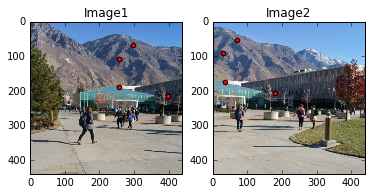

In [121]:
kp1 = vals1[1]
kp2 = vals2[1]
kp3 = vals3[1]

n1, n2, n3, n4 = RANSAC(kp1, kp2, matches1_2)

#Get the optimal transformation coordinates for the first image
dmatch = matches1_2[n1]
x0s = kp1[dmatch.queryIdx].pt[0]
y0s = kp1[dmatch.queryIdx].pt[1]
x0t = kp2[dmatch.trainIdx].pt[0]
y0t = kp2[dmatch.trainIdx].pt[1]

dmatch = matches1_2[n2]
x1s = kp1[dmatch.queryIdx].pt[0]
y1s = kp1[dmatch.queryIdx].pt[1]
x1t = kp2[dmatch.trainIdx].pt[0]
y1t = kp2[dmatch.trainIdx].pt[1]

dmatch = matches1_2[n3]
x2s = kp1[dmatch.queryIdx].pt[0]
y2s = kp1[dmatch.queryIdx].pt[1]
x2t = kp2[dmatch.trainIdx].pt[0]
y2t = kp2[dmatch.trainIdx].pt[1]

dmatch = matches1_2[n4]
x3s = kp1[dmatch.queryIdx].pt[0]
y3s = kp1[dmatch.queryIdx].pt[1]
x3t = kp2[dmatch.trainIdx].pt[0]
y3t = kp2[dmatch.trainIdx].pt[1]


plt.subplot(121),plt.scatter(x=[x0s, x1s, x2s, x3s], y=[y0s,y1s,y2s,y3s], c='r', s=20),plt.imshow(color1),plt.title('Image1')
plt.subplot(122),plt.scatter(x=[x0t, x1t, x2t, x3t], y=[y0t,y1t,y2t,y3t], c='r', s=20),plt.imshow(color2),plt.title('Image2')
plt.show()

homography1_2 = getHomography(kp1, kp2, matches1_2, n1, n2, n3, n4)


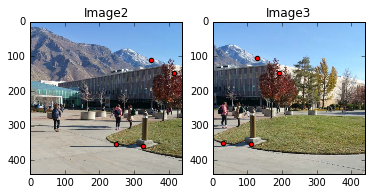

In [122]:
n1, n2, n3, n4 = RANSAC(kp3, kp2, matches3_2)

#Get the optimal transformation coordinates for the first image
dmatch = matches3_2[n1]
x0s = kp3[dmatch.queryIdx].pt[0]
y0s = kp3[dmatch.queryIdx].pt[1]
x0t = kp2[dmatch.trainIdx].pt[0]
y0t = kp2[dmatch.trainIdx].pt[1]

dmatch = matches3_2[n2]
x1s = kp3[dmatch.queryIdx].pt[0]
y1s = kp3[dmatch.queryIdx].pt[1]
x1t = kp2[dmatch.trainIdx].pt[0]
y1t = kp2[dmatch.trainIdx].pt[1]

dmatch = matches3_2[n3]
x2s = kp3[dmatch.queryIdx].pt[0]
y2s = kp3[dmatch.queryIdx].pt[1]
x2t = kp2[dmatch.trainIdx].pt[0]
y2t = kp2[dmatch.trainIdx].pt[1]

dmatch = matches3_2[n4]
x3s = kp3[dmatch.queryIdx].pt[0]
y3s = kp3[dmatch.queryIdx].pt[1]
x3t = kp2[dmatch.trainIdx].pt[0]
y3t = kp2[dmatch.trainIdx].pt[1]


plt.subplot(122),plt.scatter(x=[x0s, x1s, x2s, x3s], y=[y0s,y1s,y2s,y3s], c='r', s=20),plt.imshow(color3),plt.title('Image3')
plt.subplot(121),plt.scatter(x=[x0t, x1t, x2t, x3t], y=[y0t,y1t,y2t,y3t], c='r', s=20),plt.imshow(color2),plt.title('Image2')
plt.show()

homography3_2 = getHomography(kp3, kp2, matches3_2, n1, n2, n3, n4)


# Part D: Creating the Mosaic

In [123]:
# Edge Blurrer code, used later down the list

# Get homography of image just with edge based image
# Blur any of those lines between those to images when they composite
def getEdges(image, warp, pad_x, pad_y):
    
    #Start with a blank image
    (rows, cols, ch) = image.shape
    
    edge_image = np.zeros((rows,cols))
    
    #Trace a 3 pixel outline on the edge of the image
    edge_image[0:3,:] = 1
    edge_image[:,0:3] = 1
    edge_image[rows-3:rows,:] = 1
    edge_image[:,cols-3:cols] = 1
    
    #Warp it to get where the edges go
    edge_warped = cv2.warpPerspective(edge_image,warp,(pad_x,pad_y),flags=cv2.INTER_LINEAR)
    
    return edge_warped


In [124]:
#Get the X and Y translation inorder to modify the homography
def getTranslationVals(image, homography):
    rows, cols = image.shape

    #Define the corners of the image
    pt0 = np.matrix([[0],
                     [0],
                     [1]])

    pt1 = np.matrix([[cols],
                     [0],
                     [1]])

    pt2 = np.matrix([[0],
                     [rows],
                     [1]])

    pt3 = np.matrix([[cols],
                     [rows],
                     [1]])
    
    #Figure out where they warp to
    pt0t = np.matmul(homography, pt0)
    pt1t = np.matmul(homography, pt1)
    pt2t = np.matmul(homography, pt2)
    pt3t = np.matmul(homography, pt3)
    
    xvals = [pt0t[0][0],pt1t[0][0],pt2t[0][0],pt3t[0][0]]
    yvals = [pt0t[1][0],pt1t[1][0],pt2t[1][0],pt3t[1][0]]
    
    tx = max(xvals) - min(xvals)
    ty = max(yvals) - min(yvals)
    
    return tx, ty

tx1, ty1 = getTranslationVals(image1,homography1_2)
tx2, ty2 = getTranslationVals(image3,homography3_2)


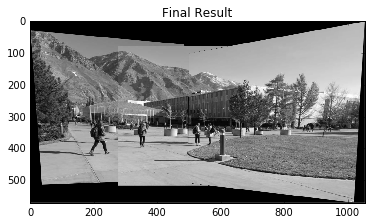

In [125]:
#Gray Scale Stitching Code
def trim(image):
    #Find the nonzero edges of the image
    pts = np.nonzero(image)
    
    i_min = min(pts[0])
    i_max = max(pts[0])
    j_min = min(pts[1])
    j_max = max(pts[1])
    
    #Only return the part of the image that is of interest
    return image[i_min:i_max+1, j_min:j_max+1]

def stitch(image1,image2):
    (rows, cols) = image1.shape
    result = np.zeros((rows,cols))
    
    #Start with the first image as the background
    result = image1
    
    #Use the second image as foreground
    pts = np.nonzero(image2)
    
    x_vals = pts[0]
    y_vals = pts[1]
    
    num_points = len(x_vals)
    
    for point in range(0,num_points):
        x = x_vals[point]
        y = y_vals[point]
        result[x][y] = image2[x][y]

    return result
                                      
def stitch3(image1,image2,image3):
    return stitch(image1, stitch(image2, image3))


def finalStitch(tx1, ty1, tx2, ty2, image1, image2, image3, homography1_2, homography3_2):

    #Build translation matrix
    T1 = np.matrix([[1, 0, tx1],
                    [0, 1, ty1],
                    [0, 0, 1]])

    #Build warp matrices
    rows1, cols1 = image1.shape
    rows2, cols2 = image2.shape
    rows3, cols3 = image3.shape

    W1 = np.matmul(T1, homography1_2)
    W2 = T1
    W3 = np.matmul(T1,homography3_2)

    pad_x = cols1+tx1+cols2+tx2+cols3
    pad_y = rows1+ty1+rows2+ty2+rows3
    
    #Warp the appropriate images
    image1_warp = cv2.warpPerspective(image1,W1,(pad_x,pad_y))
    image2_warp = cv2.warpPerspective(image2,W2,(pad_x,pad_y))
    image3_warp = cv2.warpPerspective(image3,W3,(pad_x,pad_y))
    
    result = trim(stitch3(image1_warp,image2_warp,image3_warp))
    
    return result

result = finalStitch(tx1, ty1, tx2, ty2, image1, image2, image3, homography1_2, homography3_2)

plotImage(result, "Final Result")


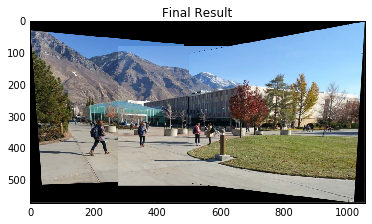

In [126]:
#Color Stitching Code
def trimC(image):
    #Find the nonzero edges of the image
    imageGrey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    pts = np.nonzero(imageGrey)
    
    i_min = min(pts[0])
    i_max = max(pts[0])
    j_min = min(pts[1])
    j_max = max(pts[1])
    
    #Only return the part of the image that is of interest
    return image[i_min:i_max+1, j_min:j_max+1]

def stitchC(image1,image2):
    
    imageGrey = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
    
    (rows, cols, ch) = image1.shape
    result = np.zeros((rows,cols))
    
    #Start with the first image as the background
    result = image1
    
    #Use the second image as foreground
    pts = np.nonzero(imageGrey)
    
    x_vals = pts[0]
    y_vals = pts[1]
    
    num_points = len(x_vals)
    
    for point in range(0,num_points):
        x = x_vals[point]
        y = y_vals[point]
        result[x][y] = image2[x][y]

    return result
                                      
def stitch3C(image1,image2,image3):
    return stitchC(image1, stitchC(image2, image3))


def finalStitchC(tx1, ty1, tx2, ty2, color1, color2, color3, homography1_2, homography3_2, withBlur=False):

    #Build translation matrix
    T1 = np.matrix([[1, 0, tx1],
                    [0, 1, ty1],
                    [0, 0, 1]])

    #Build warp matrices
    rows1, cols1, ch = color1.shape
    rows2, cols2, ch = color2.shape
    rows3, cols3, ch = color3.shape

    W1 = np.matmul(T1, homography1_2)
    W2 = T1
    W3 = np.matmul(T1,homography3_2)

    pad_x = cols1+tx1+cols2+tx2+cols3
    pad_y = rows1+ty1+rows2+ty2+rows3

    #Warp the appropriate images
    image1_warp = cv2.warpPerspective(color1,W1,(pad_x,pad_y))
    image2_warp = cv2.warpPerspective(color2,W2,(pad_x,pad_y))
    image3_warp = cv2.warpPerspective(color3,W3,(pad_x,pad_y))
    
    if withBlur:
        #Get blurring edges
        blur1_2 = getEdges(color2, W2, pad_x, pad_y)
        blur2_3 = getEdges(color3, W3, pad_x, pad_y)

        result = trimC(stitch3CBlur(image1_warp,image2_warp,image3_warp,blur1_2,blur2_3))
    
    else:
        result = trimC(stitch3C(image1_warp,image2_warp,image3_warp))
    
    return result


result = finalStitchC(tx1, ty1, tx2, ty2, color1, color2, color3, homography1_2, homography3_2)
    
plotImage(result, "Final Result")


# Full Implementation and Blurring Code

In [127]:
def stitchCBlur(image1,image2,blur1_2):
    
    imageGrey = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
    
    (rows, cols, ch) = image1.shape
    result = np.zeros((rows,cols,ch))
    
    #Start with the first image as the background
    result = image1
    
    #Use the second image as foreground
    pts = np.nonzero(imageGrey)
    
    x_vals = pts[0]
    y_vals = pts[1]
    
    num_points = len(x_vals)
    
    for point in range(0,num_points):
        x = x_vals[point]
        y = y_vals[point]
        result[x][y] = image2[x][y]

    #Blur the edges around the foreground
    pts = np.nonzero(blur1_2)
    
    x_vals = pts[0]
    y_vals = pts[1]
    
    num_points = len(x_vals)
    
    for point in range(0,num_points):
        x = x_vals[point]
        y = y_vals[point]
        
        result[x,y,0] = np.sum(image1[x-3,y,0] + image2[x+3,y,0])/2.0
        result[x,y,1] = np.sum(image1[x-3,y,1] + image2[x+3,y,1])/2.0
        result[x,y,2] = np.sum(image1[x-3,y,2] + image2[x+3,y,2])/2.0
        
    return result

def stitch3CBlur(image1,image2,image3, blur1_2, blur2_3):
    return stitchCBlur(image1, stitchCBlur(image2, image3,blur2_3), blur1_2)

def imageStitch(fn1, fn2, fn3, withBlur):
    
    color1, color2, color3, image1, image2, image3 = getImages(fn1,fn2,fn3)
    vals1, vals2, vals3 = getKeyPoints(image1, image2, image3)   
    img1_2, matches1_2 = bfMatcher(vals1,vals2,image1,image2)
    img3_2, matches3_2 = bfMatcher(vals3,vals2,image3,image2)
    n1, n2, n3, n4 = RANSAC(vals1[1],vals2[1],matches1_2)
    homography1_2 = getHomography(vals1[1],vals2[1],matches1_2,n1,n2,n3,n4)
    n1, n2, n3, n4 = RANSAC(vals3[1],vals2[1],matches3_2)
    homography3_2 = getHomography(vals3[1],vals2[1],matches3_2,n1,n2,n3,n4)
    tx1, ty1 = getTranslationVals(image1,homography1_2)
    tx2, ty2 = getTranslationVals(image3,homography3_2)
    
    result = finalStitchC(tx1, ty1, tx2, ty2, color1, color2, color3, homography1_2, homography3_2, withBlur)

    return result

# Full Stitcher

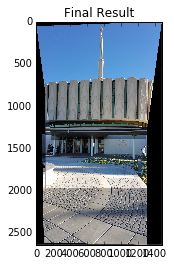

True

In [132]:
# fn1 = 'stitch1.jpg'
# fn2 = 'stitch2.jpg'
# fn3 = 'stitch3.jpg'

fn1 = 'temple_vertical1_1200.png'
fn2 = 'temple_vertical2_1200.png'
fn3 = 'temple_vertical3_1200.png'

# Turn this on if you want to see my failed edge blurrer
withEdgeBlur = False

result = imageStitch(fn1,fn2,fn3,withEdgeBlur)

plotImage(result, "Final Result")

cv2.imwrite("Stiched_Result_Color.png", cv2.cvtColor(result,cv2.COLOR_RGB2BGR))
